In [9]:
import numpy
from etrade.spot.trader import Station
from etrade.spot.market.recycle import BasicRecycle, PointwiseRecycle
from etrade.spot.forecast.market import DistributiveSeries, DistributiveMarket
from  data_utils.stochastic_utils.vdistributions.abstract import AbstractDistribution
from data_utils.stochastic_utils.vdistributions.parameter.continuous.basic import NormalDistribution, LogNormalDistribution, eps
from data_utils.stochastic_utils.vdistributions.parameter.continuous.heavytail import StudentTDistribution
from data_utils.stochastic_utils.vdistributions.nonparametric.continuous.histogram import HistogramDistribution, LogHistogramDistribution
from data_utils.stochastic_utils.vdistributions.nonparametric.continuous.kernel2 import KernelMixDistribution
from data_utils.stochastic_utils.vdistributions.nonparametric.discrete.basic import DiscreteDistribution
from data_utils.stochastic_utils.vdistributions.tools.convert import resample_like_distribution, generate_correlated_sample_matrix
from data_utils.stochastic_utils.vdistributions.tools.divergence import kl_divergence_continuous, crps

from matplotlib import pyplot as plt

from scipy.optimize import differential_evolution

from matplotlib import pyplot

In [2]:
s = Station("station", 50)
monte_carlo_num = 1000

In [3]:
original = NormalDistribution(35,5)
# student = DiscreteDistribution([[10, 0.2], [20, 0.5], [30,0.3]])

0.27608012820305905


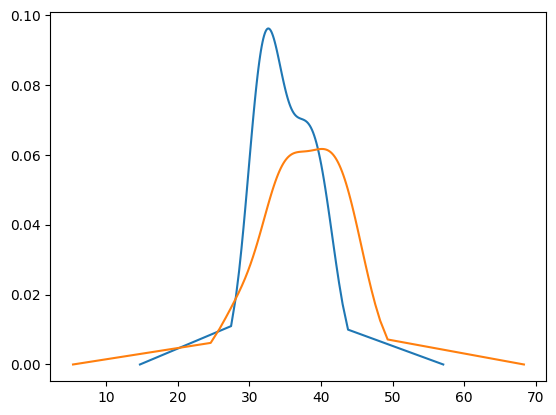

In [4]:
r = original.rvf(2000)
paired = numpy.random.choice(r, 10), numpy.random.choice(r, 10)
d = KernelMixDistribution(paired[0], 10), KernelMixDistribution(paired[1], 10)
pyplot.plot(d[0].curves()[1][:,0], d[0].curves()[1][:,1])
pyplot.plot(d[1].curves()[1][:,0], d[1].curves()[1][:,1])
print(kl_divergence_continuous(*d))

In [5]:
def f(x):
    return numpy.log(d[0].pdf(x)) * -1
print(
    differential_evolution(f, [(eps, 50.0)]).x
)

[32.65509751]


In [6]:
print(crps(d[0], 34.54618333))

1.0520001605018963


In [8]:
print(NormalDistribution(0, 2).moment_integral())

[0. 4. 0. 3.]


In [17]:
def paired_dist(seed_dist:AbstractDistribution, seed_len, sample_len):
    seed = seed_dist.rvf(seed_len)
    d0_data, d1_data = numpy.random.choice(seed, sample_len), numpy.random.choice(seed, sample_len)
    d0, d1 = KernelMixDistribution(d0_data, sample_len), KernelMixDistribution(d1_data, sample_len)
    return d0, d1
    

In [19]:
print(paired_dist(NormalDistribution(25, 5), 100, 50))

({'KernelMixDistribution': [{'NormalDistribution': {'mu': 17.284509583597707, 'sigma': 2.018274258120374}}, {'NormalDistribution': {'mu': 18.922659547175883, 'sigma': 2.018274258120374}}, {'NormalDistribution': {'mu': 18.922659547175883, 'sigma': 2.018274258120374}}, {'NormalDistribution': {'mu': 19.02478283503188, 'sigma': 2.018274258120374}}, {'NormalDistribution': {'mu': 19.02478283503188, 'sigma': 2.018274258120374}}, {'NormalDistribution': {'mu': 19.482971745739835, 'sigma': 2.018274258120374}}, {'NormalDistribution': {'mu': 19.895826509559438, 'sigma': 2.018274258120374}}, {'NormalDistribution': {'mu': 20.266716270284764, 'sigma': 2.018274258120374}}, {'NormalDistribution': {'mu': 20.754779594249865, 'sigma': 2.018274258120374}}, {'NormalDistribution': {'mu': 20.810505645164564, 'sigma': 2.018274258120374}}, {'NormalDistribution': {'mu': 21.00362107060011, 'sigma': 2.018274258120374}}, {'NormalDistribution': {'mu': 21.51166935791353, 'sigma': 2.018274258120374}}, {'NormalDistribu

In [66]:
pdl = [paired_dist(NormalDistribution(25, 5), 2000, 50) for _ in range(4)]

In [67]:
[crps(i[0], i[1].rvf_scalar())  for i in pdl]

[1.6882976951716562, 1.82443334676573, 4.182898670747029, 1.4340005251319174]

In [68]:
aq = DistributiveSeries(*[i[0] for i in pdl])
aaq = DistributiveSeries(*[i[1] for i in pdl])
dp = DistributiveSeries(LogNormalDistribution(0, 0.1), LogNormalDistribution(0, 0.2), LogNormalDistribution(0, 0.3), LogNormalDistribution(0, 0.1))
rp = DistributiveSeries(LogNormalDistribution(0, 0.5), LogNormalDistribution(0, 0.3), LogNormalDistribution(0, 0.1), LogNormalDistribution(0, 0.1))

In [69]:
market = DistributiveMarket(aq, dp, rp)
a_market = DistributiveMarket(aaq, dp, rp)
train_aq, train_dp, train_rp = market.rvf(monte_carlo_num)
test_aq, test_dp, test_rp = a_market.rvf(monte_carlo_num)

In [75]:
br = PointwiseRecycle(0.8, 1.5)
result = market.submitted_quantity_optimizer(s, br, train_aq, train_dp, train_rp)
print(result.x)
print([i.mean_integral() for i in aq.distributions])

[19.87250914 21.25298061 20.63393269 20.52137194]
[25.428907998725137, 24.904665048256422, 24.294297215352202, 25.55341191048018]


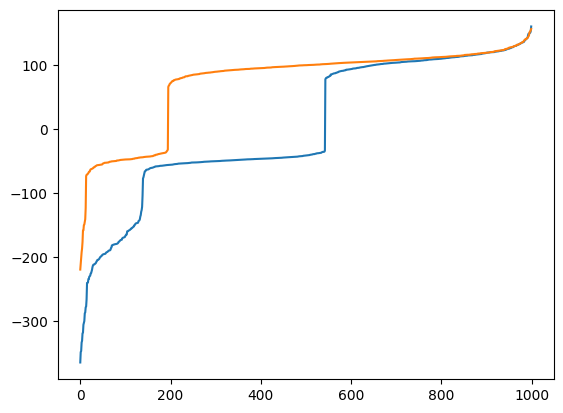

In [76]:
pyplot.plot(numpy.sort(market.trade_with_recycle(s, br, train_aq, train_dp, train_rp, [i.mean_integral() for i in aq.distributions])))
pyplot.plot(numpy.sort(market.trade_with_recycle(s, br, train_aq, train_dp, train_rp, result.x)))

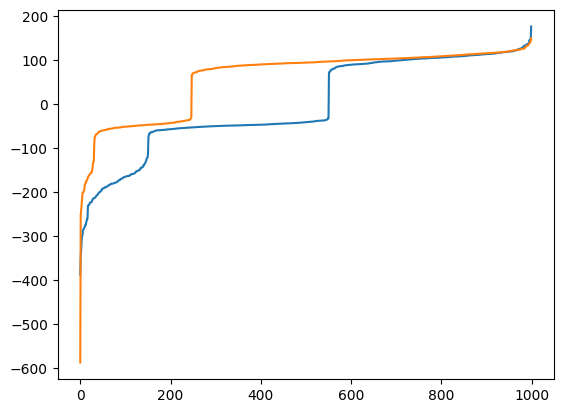

In [79]:
pyplot.plot(numpy.sort(DistributiveMarket.trade_with_recycle(s, br, test_aq, test_dp, test_rp, [i.mean_integral() for i in aaq.distributions])))
pyplot.plot(numpy.sort(DistributiveMarket.trade_with_recycle(s, br, test_aq, test_dp, test_rp, result.x)))
# pyplot.plot(numpy.sort(market.trade_with_recycle(s, br, train_aq, train_dp, train_rp, result.x)))

In [77]:
a